# Séries temporais com Regressão Linear

**Autor**: Maykon Schots

**Participação especial**: Rafael Barbosa

In [70]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import holidays


#--- Configurações adicionais

plt.style.use("seaborn-muted")
pd.set_option('display.max_columns', None)

In [71]:
dados = pd.read_csv("data/output-dados-case.csv")
dados["Lead Created At"] = pd.to_datetime(dados["Lead Created At"], format = "%Y-%m-%d")

dados.head()

,Lead Created At,Lead Id,Purchase Source,JID,tempo_jornada,flag_jornada,flag_venda,Canal
0,2020-01-06 22:39:00,MSS-00003108-bf9d-4679-8780-36931ab4ae49-2020,fb-geral-lookalike-dco,1,1.0,Primeiro Contato,0.0,FB
1,2020-02-21 19:18:00,MSS-00003108-bf9d-4679-8780-36931ab4ae49-2020,sms-pre-carnaval-abandono,2,47.0,Ultimo Contato,0.0,SMS
2,2020-05-13 14:15:00,MSS-000031d0-5499-4e58-a88d-9afbcbb8ee9a-2019,yt-rmkt-videos-videovendas3,3,143.0,Ultimo Contato,0.0,YT
3,2020-07-23 22:28:00,MSS-00003bb2-b409-47b3-862f-e6c82b311d0c-2020,insta-bio,1,1.0,Primeiro Contato,0.0,FB
4,2020-05-12 22:51:00,MSS-0000610b-1170-47f5-990b-239d6eaef81b-2020,fb-rmkt-video-dco,1,1.0,Primeiro Contato,0.0,FB


In [72]:
dados["indicador_leads"] = 1

#--- Soma de vendas

vol_diarios_compras = dados[dados["flag_venda"] == 1].resample("D", on = "Lead Created At")["indicador_leads"].sum()

vol_diarios_compras.head()

Lead Created At
2020-01-01    47
2020-01-02    70
2020-01-03    48
2020-01-04    81
2020-01-05    73
Freq: D, Name: indicador_leads, dtype: int64

## 4. Modelagem - Regressão Linear


**Objetivo**: Previsão de vendas diária para os próximos 7 dias

### 4.1. Visualização da série temporal

In [73]:
df_vol_diarios_compras = vol_diarios_compras.reset_index(drop = 0)
df_vol_diarios_compras["Legenda"] = df_vol_diarios_compras["Lead Created At"].apply(lambda x: "Treino" if str(x) < "2020-07-01" else "Teste")

df_vol_diarios_compras.head()

,Lead Created At,indicador_leads,Legenda
0,2020-01-01,47,Treino
1,2020-01-02,70,Treino
2,2020-01-03,48,Treino
3,2020-01-04,81,Treino
4,2020-01-05,73,Treino


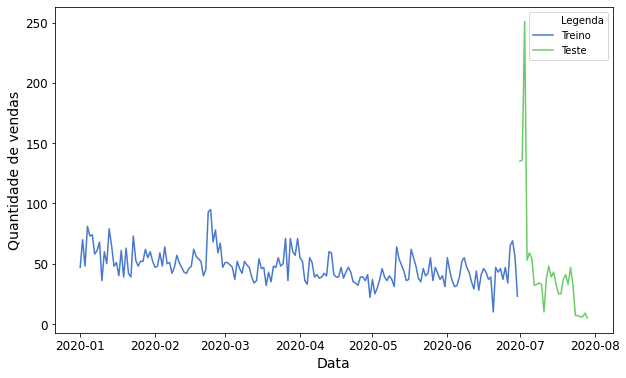

In [74]:
_ = plt.figure(figsize = [10, 6])
_ = sns.lineplot(x = "Lead Created At", y = "indicador_leads", hue = "Legenda", data = df_vol_diarios_compras, color = "black")
_ = plt.xlabel("Data", fontsize = 14, color = "black")
_ = plt.ylabel("Quantidade de vendas", fontsize = 14, color = "black")
_ = plt.tick_params(axis = "x", labelsize = 12, labelcolor = "black")
_ = plt.tick_params(axis = "y", labelsize = 12, labelcolor = "black")

### 4.2. Variáveis para a modelagem

#### 4.2.1. Variável resposta: Quantidade de compras por mês 

In [75]:
dados1 = pd.DataFrame(vol_diarios_compras).reset_index()

dados1["indicador_leads"] = dados1["indicador_leads"]*1.0

dados1.head()

,Lead Created At,indicador_leads
0,2020-01-01,47.0
1,2020-01-02,70.0
2,2020-01-03,48.0
3,2020-01-04,81.0
4,2020-01-05,73.0


#### 4.2.2. Variável explicativa: Volume diário médio da jornada

In [76]:
dados2 = pd.DataFrame(dados.resample("D", on = "Lead Created At")["tempo_jornada"].mean()).reset_index()

dados2.head()

,Lead Created At,tempo_jornada
0,2020-01-01,29.451766
1,2020-01-02,27.240385
2,2020-01-03,33.897341
3,2020-01-04,27.859436
4,2020-01-05,35.575490


#### 4.2.3. Join entre as primeiras variáveis

In [77]:
of_dados = pd.merge(dados1, dados2, on = ["Lead Created At"])

of_dados.head()

,Lead Created At,indicador_leads,tempo_jornada
0,2020-01-01,47.0,29.451766
1,2020-01-02,70.0,27.240385
2,2020-01-03,48.0,33.897341
3,2020-01-04,81.0,27.859436
4,2020-01-05,73.0,35.575490


#### 4.2.4. Variáveis explicativa: É feriado?

In [78]:
first_date = of_dados["Lead Created At"].min()
last_date = of_dados["Lead Created At"].max()

f"A primeira informação disponível é datada em {first_date} e a última é de {last_date}"

'A primeira informação disponível é datada em 2020-01-01 00:00:00 e a última é de 2020-07-29 00:00:00'

In [79]:
feriados = holidays.Brazil()

feriados_br = pd.DataFrame({"x": feriados["2020-01-01": "2020-07-31"]})
feriados_br["x"] = pd.to_datetime(feriados_br["x"], format = "%Y-%m-%d")

of_dados = pd.merge(of_dados, feriados_br, how="left", indicator = True, left_on = "Lead Created At", right_on= "x")
of_dados["feriado"] = np.where(of_dados["_merge"] == "both", 1, 0)
of_dados = of_dados.drop(["x", "_merge"], axis = 1)


of_dados.head()

,Lead Created At,indicador_leads,tempo_jornada,feriado
0,2020-01-01,47.0,29.451766,1
1,2020-01-02,70.0,27.240385,0
2,2020-01-03,48.0,33.897341,0
3,2020-01-04,81.0,27.859436,0
4,2020-01-05,73.0,35.575490,0


#### 4.2.6. Variáveis explicativa: Comuns de séries temporais

In [80]:
import datetime

of_dados["day"] = of_dados["Lead Created At"].apply(lambda t: t.day)
of_dados["weekday"] = of_dados["Lead Created At"].apply(lambda x: x.weekday())

of_dados.head()

,Lead Created At,indicador_leads,tempo_jornada,feriado,day,weekday
0,2020-01-01,47.0,29.451766,1,1,2
1,2020-01-02,70.0,27.240385,0,2,3
2,2020-01-03,48.0,33.897341,0,3,4
3,2020-01-04,81.0,27.859436,0,4,5
4,2020-01-05,73.0,35.575490,0,5,6


#### 4.2.5. É fim de semana?

In [81]:
of_dados["is_weekend"] = of_dados["weekday"].apply(lambda x: 1 if x in (5, 6) else 0)

of_dados.head()

,Lead Created At,indicador_leads,tempo_jornada,feriado,day,weekday,is_weekend
0,2020-01-01,47.0,29.451766,1,1,2,0
1,2020-01-02,70.0,27.240385,0,2,3,0
2,2020-01-03,48.0,33.897341,0,3,4,0
3,2020-01-04,81.0,27.859436,0,4,5,1
4,2020-01-05,73.0,35.575490,0,5,6,1


#### 4.2.7. Variáveis explicativa: Lags

In [82]:
for i in range(4, 10):        
    of_dados["lag_{}".format(i)] = of_dados["indicador_leads"].shift(i)  
    
of_dados.head()

,Lead Created At,indicador_leads,tempo_jornada,feriado,day,weekday,is_weekend,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9
0,2020-01-01,47.0,29.451766,1,1,2,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-02,70.0,27.240385,0,2,3,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-03,48.0,33.897341,0,3,4,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-04,81.0,27.859436,0,4,5,1,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-05,73.0,35.575490,0,5,6,1,47.0,NaN,NaN,NaN,NaN,NaN


### 4.3. Separando em treino e teste

In [83]:
treino = of_dados[of_dados["Lead Created At"] < "2020-07-01"]

x_treino = treino.drop(["Lead Created At", "indicador_leads"], axis = 1)
y_treino = treino["indicador_leads"]

In [84]:
teste = of_dados[of_dados["Lead Created At"] >= "2020-07-01"]

x_teste = teste.drop(["Lead Created At", "indicador_leads"], axis = 1)
y_teste = teste["indicador_leads"]